In [1]:
#!/usr/bin/python
# -*- coding: UTF-8 -*-
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob

In [2]:
def plot_contrast_imgs(origin_img, converted_img, origin_img_title="origin_img", converted_img_title = "converted_img", converted_img_gray=False):
    """
    用于对比显示两幅图像
    """
    
    fig,(ax1, ax2) = plt.subplots(1, 2, figsize=(15, 20))
    ax1.set_title(origin_img_title)
    ax1.imshow(origin_img)
    ax2.set_title(converted_img_title)
    if converted_img_gray==True:
        ax2.imshow(converted_img, cmap="gray")
    else:
        ax2.imshow(converted_img)
    plt.show()

In [3]:
# 定义棋盘横向和纵向的角点个数
nx = 9
ny = 6
def cal_calibrate_params(file_paths):
    """
    计算相机校准参数,把对象点的坐标和检测的角点坐标一一对应
    """
    
    object_points = []
    image_points = []
    # 对象点的坐标
    objp = np.zeros((nx*ny , 3), np.float32)
    objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1, 2)
    # 检测每幅图像角点坐标
    for file_path in file_paths:
        img = mpimg.imread(file_path)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        rect, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
        if rect == True:
            object_points.append(objp)
            image_points.append(corners)
    # 获取畸变系数
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(object_points, image_points, gray.shape[::-1], None, None)
    return ret, mtx, dist, rvecs, tvecs

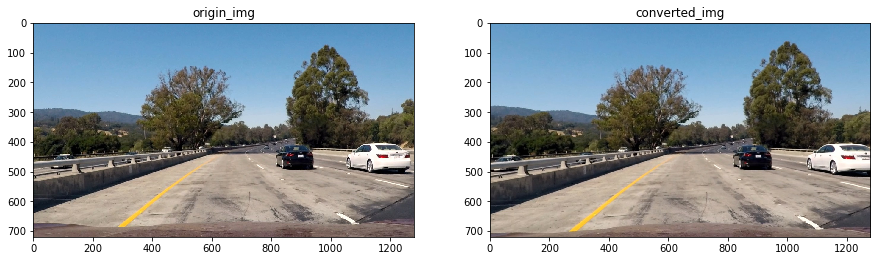

done!


In [16]:
def img_undistort(img, mtx, dist):
    """
    图像去畸变
    """
    return cv2.undistort(img, mtx, dist, None, mtx)

# 测试去畸变函数的效果
file_paths = glob.glob("./camera_cal/calibration*.jpg")
ret, mtx, dist, rvecs, tvecs = cal_calibrate_params(file_paths)
if mtx != None:
    img = mpimg.imread("./test_images/test1.jpg")
    undistort_img = img_undistort(img, mtx, dist)
    plot_contrast_imgs(img, undistort_img)
    print("done!")
else:
    print("failed")

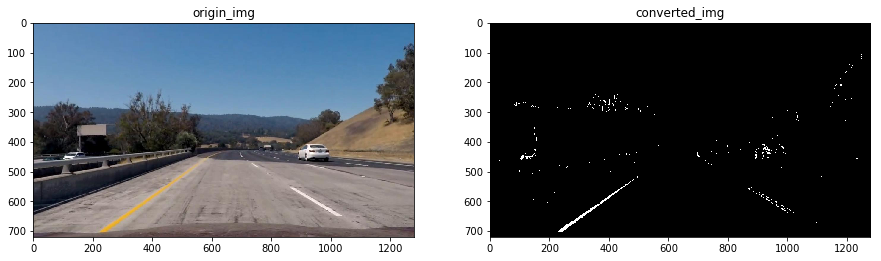

In [5]:
def pipeline(img, s_thresh=(170, 255), sx_thresh=(40, 200)):
    """
    使用sobel和选择颜色空间对图像进行处理
    """
    
    img = np.copy(img)
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    h_channel = hls[:,:,0]
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Sobel y
    sobely = cv2.Sobel(l_channel, cv2.CV_64F, 0, 1) # Take the derivative in x
    abs_sobely = np.absolute(sobely) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobely/np.max(abs_sobely))
    
    # Threshold x gradient
    sxbinarx = np.zeros_like(scaled_sobel)
    sxbinarx[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1]) ] = 1
    color_binary = np.zeros_like(sxbinary)
    color_binary[((sxbinary ==1) | (s_binary==1)) & (l_channel>100)] = 1
    return color_binary

# 测试使用sobel和选择颜色空间
img = mpimg.imread("./test/frame45.jpg")
result = pipeline(img)
plot_contrast_imgs(img, result, converted_img_gray=True)

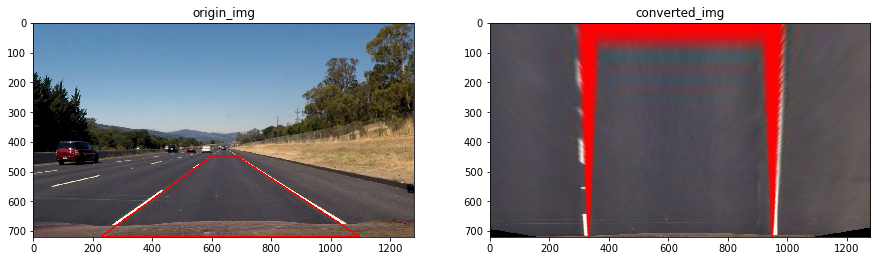

In [21]:
def cal_perspective_params(img, points):
    """
    计算透视变换参数
    """
    
    offset_x = 330
    offset_y = 0
    img_size = (img.shape[1], img.shape[0])
    src = np.float32(points)
    dst = np.float32([[offset_x, offset_y], [img_size[0]-offset_x, offset_y],
                      [offset_x, img_size[1]-offset_y],
                      [img_size[0]-offset_x, img_size[1]-offset_y]
                ])
    M = cv2.getPerspectiveTransform(src, dst)
    M_inverse = cv2.getPerspectiveTransform(dst, src)
    return M, M_inverse
   

def img_perspect_transform(img, M):
    '''
    图像透视变换
    '''
    
    img_size = (img.shape[1], img.shape[0])
    return cv2.warpPerspective(img, M, img_size)

# 获取透视变换参数,每一个角度拍摄的透视变换矩阵都不一样
# 但是车辆的摄像头的位置固定，角度是固定的，用同一个透视转换矩阵就可以不用重复计算
img = mpimg.imread("./test_images/straight_lines2.jpg")
img = cv2.line(img, (601, 448), (683, 448), (255,0,0),3)
img = cv2.line(img, (683, 448), (1097, 717), (255,0,0),3)
img = cv2.line(img, (1097, 717), (230, 717), (255,0,0),3)
img = cv2.line(img, (230, 717), (601, 448), (255,0,0),3)
img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
cv2.imwrite("./test_images/straight_lines2_line.jpg", img)
undistort_img = img_undistort(img, mtx, dist)
points = [[601, 448], [683, 448], [230, 717], [1097, 717]]
M, M_inverse = cal_perspective_params(img, points)

# 测试透视图变换
if M != None:
    origin_img = mpimg.imread("./test_images/straight_lines2_line.jpg")
    undistort_img = img_undistort(origin_img, mtx, dist)
    transform_img = img_perspect_transform(undistort_img, M)
    plot_contrast_imgs(origin_img, transform_img, converted_img_gray=True)
else:
    print("transform failed!")

In [7]:
def cal_line_param(binary_warped):
    """
    binary_warped：图像处理过后的二值图像
    """
    
    # 图像的下半部分直方图统计
    histogram = np.sum(binary_warped[int(binary_warped.shape[0]/2):,:], axis=0)
    # 在统计结果中找到左右最大的点的位置，作为左右车道检测的开始点
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    # 设置滑动窗口的数量，计算每一个窗口的高度
    nwindows = 9
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # 获取图像中不为0的点
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # 车道检测的当前位置
    leftx_current = leftx_base
    rightx_current = rightx_base
    # 设置x的检测范围
    margin = 100
    # 设置最小像素点
    minpix = 50
    # 记录检测出的左右车道点
    left_lane_inds = []
    right_lane_inds = []

    # 遍历该副图像中的每一个窗口
    for window in range(nwindows):
        # 设置窗口的x,y的检测范围
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        
        # 获得在窗口内部，且不为0的点
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # 如果获取的点的个数大于最小个数，把该点集合的平均值设置当前点
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
    
    # 把检测出所有左右车道点分别进行合并
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)
    
    # 在图像中获取这些点
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 
    
    # 用曲线拟合检测出的点
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    return left_fit,right_fit

In [8]:
def cal_line__center(img):
    """
    计算图像的中心点
    
    """
    
    undistort_img = img_undistort(img, mtx, dist)
    rigin_pipline_img = pipeline(undistort_img)
    transform_img = img_perspect_transform(rigin_pipline_img, M)
    left_fit,right_fit = cal_line_param(transform_img)
    y_max = img.shape[0] 
    left_x = left_fit[0]*y_max**2 + left_fit[1]*y_max + left_fit[2]
    right_x = right_fit[0]*y_max**2 + right_fit[1]*y_max + right_fit[2]
    return (left_x+right_x)/2

# 假设straight_lines2_line.jpg，这张图片是位于车道的中央，实际情况可以根据测量验证.
img = mpimg.imread("./test_images/straight_lines2_line.jpg")
lane_center = cal_line__center(img)
print("车道的中心点为：{}".format(lane_center))

车道的中心点为：639.6203539620328


In [9]:
def fill_lane_poly(img, left_fit, right_fit):
    """
    根据拟合的曲线，画出两条车道线之间的多边形
    """
    
    y_max = img.shape[0]
    out_img = np.dstack((img, img, img))*255
    left_ponits = [[left_fit[0]*y**2 + left_fit[1]*y + left_fit[2], y] for y in range(y_max)]
    right_ponits = [[right_fit[0]*y**2 + right_fit[1]*y + right_fit[2], y] for y in range(y_max-1, -1, -1)]
    line_points = np.vstack((left_ponits,right_ponits))
    cv2.fillPoly(out_img, np.int_([line_points]), (0,255, 0))
    return out_img

In [10]:
def cal_radius(img, left_fit, right_fit):
    """
    把曲线转换到真实环境中，计算曲线的曲率
    """

    # 像素点和真实场景中的比率
    ym_per_pix = 30/720
    xm_per_pix = 3.7/700

    # 计算得到曲线上的每个点
    left_y_axis = np.linspace(0, img.shape[0], img.shape[0]-1)
    left_x_axis = left_fit[0]*left_y_axis**2 + left_fit[1]*left_y_axis + left_fit[2]
    right_y_axis = np.linspace(0, img.shape[0], img.shape[0]-1)
    right_x_axis = right_fit[0]*right_y_axis**2 + right_fit[1]*right_y_axis + right_fit[2]

    # 获取真实环境中的曲线
    left_fit_cr = np.polyfit(left_y_axis*ym_per_pix, left_x_axis*xm_per_pix, 2)
    right_fit_cr = np.polyfit(right_y_axis*ym_per_pix, right_x_axis*xm_per_pix, 2)
    
    # 获得真实环境中的曲线曲率
    left_curverad = ((1 + (2*left_fit_cr[0]*left_y_axis*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*right_y_axis*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    # 在图像上显示曲率
    cv2.putText(img,'Radius of Curvature = {}(m)'.format(np.mean(left_curverad)), (20,50),cv2.FONT_ITALIC, 1 , (255,255,255), 5)
    return img

In [11]:
def cal_center_departure(img, left_fit, right_fit):
    """
    计算中心点偏移
    """
    
    # 计算中心点
    y_max = img.shape[0] 
    left_x = left_fit[0]*y_max**2 + left_fit[1]*y_max + left_fit[2]
    right_x = right_fit[0]*y_max**2 + right_fit[1]*y_max + right_fit[2]
    xm_per_pix = 3.7 / 700
    center_depart = ((left_x+right_x) / 2 - lane_center)*xm_per_pix
    
    # 在图像上显示偏移
    if center_depart > 0:
        cv2.putText(img,'Vehicle is {}m right of center'.format(center_depart), (20,100),cv2.FONT_ITALIC, 1 , (255,255,255), 5)
    elif center_depart < 0:
        cv2.putText(img,'Vehicle is {}m left of center'.format(-center_depart), (20,100),cv2.FONT_ITALIC, 1 , (255,255,255), 5)
    else:
        cv2.putText(img,'Vehicle is in the center', (20,100),cv2.FONT_ITALIC, 1 , (255,255,255), 5)
    return img

In [12]:
def process_image(img):
    """
    图像处理，将上面的所有方法进行汇总
    """
    
    undistort_img = img_undistort(img, mtx, dist)
    rigin_pipline_img = pipeline(undistort_img)
    transform_img = img_perspect_transform(rigin_pipline_img, M)
    left_fit, right_fit = cal_line_param(transform_img)
    
    result = fill_lane_poly(transform_img, left_fit, right_fit)
    transform_img_inverse = img_perspect_transform(result, M_inverse)
    
    transform_img_inverse = cal_radius(transform_img_inverse, left_fit, right_fit)
    transform_img_inverse = cal_center_departure(transform_img_inverse, left_fit, right_fit)
    transform_img_inverse = cv2.addWeighted(undistort_img, 1, transform_img_inverse, 0.5, 0)
    return transform_img_inverse

In [13]:
from moviepy.editor import VideoFileClip

clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(process_image)
#white_clip.write_images_sequence("test_challenge/frame%2d.jpg")
white_clip.write_videofile("project_video_output.mp4", audio=False)

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████▉| 1260/1261 [04:40<00:00,  4.34it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 



In [14]:
from IPython.display import HTML

output = 'project_video_output.mp4'
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output))